In [1]:
import pandas
from sklearn import metrics
import time
import gc
import random
import xgboost as xgb
import json
from matplotlib import pyplot as plt

In [2]:
df = pandas.read_csv('data/dataset_400features.large.csv')
df

,borrower,snapshot,project,2u_defix,2v_04,2w_1,2a_03u_defix,2a_03v_04,2a_03w_1,2b_05,...,2s_t_9ff58f4ffb29fa2,2s_t_ffc97d72e13e010,2s_t_a06bc25b5805d5f,2s_t_6c3c78838c761c6,2s_a_04v_02,2s_a_02t_3b484b82567a09e,2a_03t_35a18000230da77,2s_a_03t_ae7ab96520de3a1,origin,label
0,0xe8215f5aee29a1db273c80c9d269e8fa44b39126,2021-02,Aave,77.0,39.0,80.0,16.0,11.0,18.0,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,0
1,0xf8219bd4d474a8ed9e4041d6cae01467f3ee1e56,2022-05,Aave,22.0,15.0,50.0,2.0,2.0,7.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,0
2,0xf9a6ed52c4988580954672aa91a1d5eb229e5c78,2021-10,Aave,16.0,42.0,78.0,3.0,5.0,8.0,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,0
3,0x8032244b3b41b487d8de22363bc436e869e6859f,2022-06,Aave,26.0,16.0,60.0,2.0,3.0,13.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,1
4,0x8032244b3b41b487d8de22363bc436e869e6859f,2022-03,Aave,20.0,4.0,28.0,2.0,2.0,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204730,0x0524fe637b77a6f5f0b3a024f7fd9fe1e688a291,2022-07,Compound,385.0,155.0,331.0,86.0,38.0,59.0,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0
204731,0x0524fe637b77a6f5f0b3a024f7fd9fe1e688a291,2022-08,Compound,398.0,158.0,343.0,87.0,38.0,60.0,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0
204732,0x0524fe637b77a6f5f0b3a024f7fd9fe1e688a291,2022-09,Compound,409.0,161.0,353.0,91.0,39.0,63.0,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0
204733,0x5f75fb6104ac8ce72879347db1041adf2f7745d6,2021-07,Compound,28.0,14.0,45.0,8.0,3.0,11.0,3.0,...,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,True,0


In [3]:
not_features = [
    'borrower',
    'snapshot',
    'project',
    'origin',
    'label'
]

In [4]:
fs = [x for x in df.columns if x not in not_features]
len(fs)

400

In [5]:
list_address = set(df['borrower'].unique())
len(list_address)

58232

In [6]:
list_address_aave = set(df[df['project']=='Aave']['borrower'].unique())
len(list_address_aave)

42619

In [7]:
list_address_compound = set(df[df['project']=='Compound']['borrower'].unique())
len(list_address_compound)

20652

In [8]:
list_address_common = [x for x in list_address_aave if x in list_address_compound]
len(list_address_common)

5039

In [9]:
bst = xgb.Booster()
bst.load_model('models/xgb400_aave_only')

In [10]:
df['score'] = bst.predict(xgb.DMatrix(df[fs]))
df['score_q'] = pandas.qcut(df['score'], 5, labels=False)

In [11]:
df_train = df[(df['project']=='Aave') & (~df['borrower'].isin(list_address_common)) & (df['snapshot']<'2022-05')]
len(df_train)

80784

In [12]:
list_address_trained = set(df_train['borrower'].unique())
len(list_address_trained)

22096

In [13]:
df_valid = df[(df['project']=='Aave') & (df['snapshot']=='2022-05')]
len(df_valid)

9575

In [14]:
df_test1 = df[(df['project']=='Aave') & (df['snapshot']>'2022-05') & (df['snapshot']<'2022-09')]
len(df_test1)

14042

In [15]:
df_test2 = df[(df['project']=='Aave') & (df['snapshot']>'2022-05') & (df['snapshot']<'2022-09') \
              & (~df['borrower'].isin(list_address_trained))]
len(df_test2)

10203

In [16]:
df_test3 = df[(df['project']=='Compound') & (df['snapshot']>'2022-05') & (df['snapshot']<'2022-09')]
len(df_test3)

2625

In [17]:
df_test4 = df[(df['snapshot']>'2022-05') & (df['snapshot']<'2022-09')]
len(df_test4)

16667

In [18]:
df_test5 = df[(df['snapshot']>'2022-05') & (df['snapshot']<'2022-09') \
              & (~df['borrower'].isin(list_address_trained))]
len(df_test5)

12828

In [19]:
df_test_past = df[(df['project']=='Compound') & (df['snapshot']<='2022-05')]
len(df_test_past)

73125

In [20]:
def score_auc(df_eval):
    return metrics.roc_auc_score(df_eval['label'], df_eval['score'])

In [21]:
score_auc(df_train)

0.7339074507602782

In [22]:
score_auc(df_valid)

0.6909180206010407

In [23]:
score_auc(df_test1)

0.6631289142559671

In [24]:
score_auc(df_test2)

0.6075149506030528

In [25]:
score_auc(df_test3)

0.5783808185139561

In [26]:
score_auc(df_test4)

0.64586965499158

In [27]:
score_auc(df_test5)

0.6172860214837015

In [28]:
score_auc(df_test_past)

0.588242775845776

In [29]:
def slope_curve(df_eval, title):   
    auc = score_auc(df_eval)
    title = title + ' (AUC='+"{:.2f}".format(auc)+')'
    sloping = df_eval.groupby('score_q').agg({'borrower':'count', 'label':'mean'})
    labels_x = ['1-Lower risk', '2', '3', '4', '5-Higher risk']
    fig,ax = plt.subplots()
    
    ax.bar(labels_x, sloping['borrower'], color="blue")
    ax.set_xlabel("Model Score Group", fontsize = 14)
    ax.set_ylabel("Num borrowers",color="blue",fontsize=14)
    
    ax2=ax.twinx()
    ax2.plot(labels_x, sloping['label'], color="orange", marker="o")
    ax2.set_ylabel("Actual Liquidations", color="orange", fontsize=14)
    
    plt.title(title)
    plt.show()

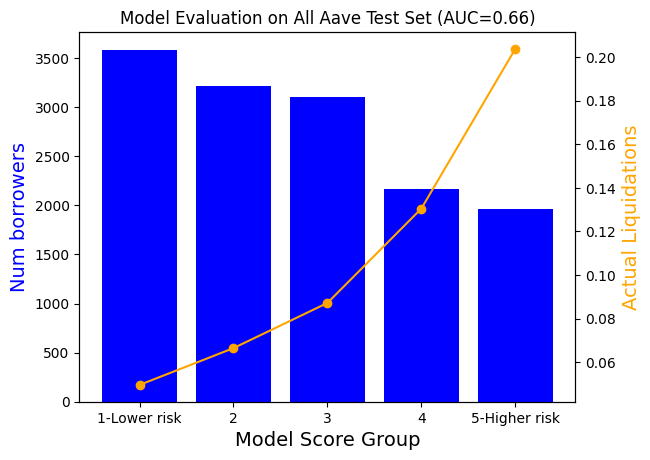

In [30]:
slope_curve(df_test1, 'Model Evaluation on All Aave Test Set')

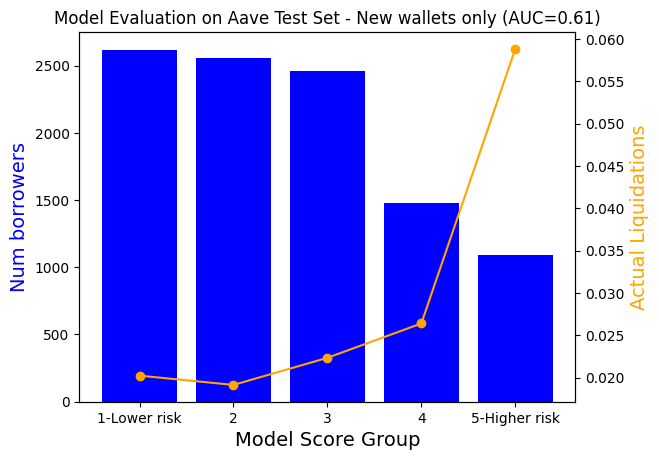

In [31]:
slope_curve(df_test2, 'Model Evaluation on Aave Test Set - New wallets only')

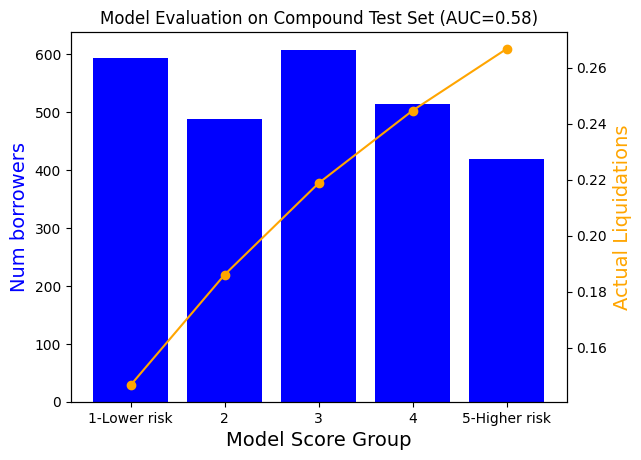

In [32]:
slope_curve(df_test3, 'Model Evaluation on Compound Test Set')

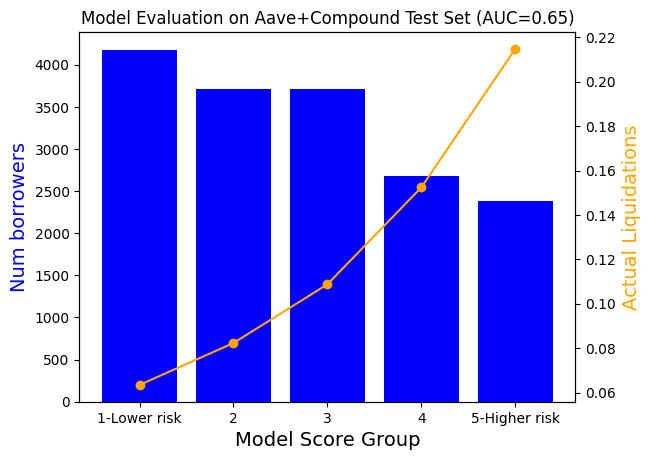

In [33]:
slope_curve(df_test4, 'Model Evaluation on Aave+Compound Test Set')

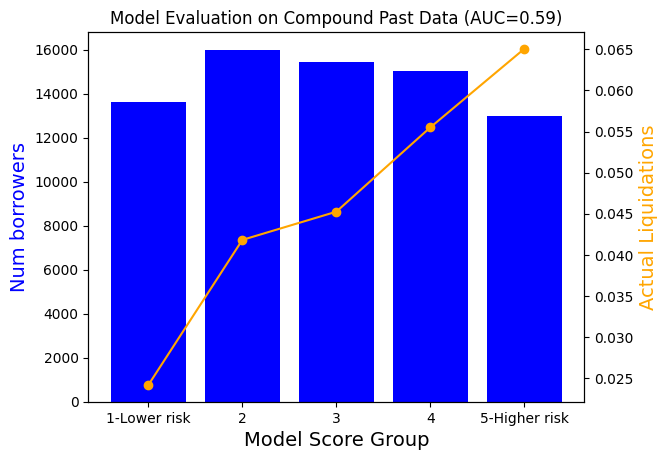

In [34]:
slope_curve(df_test_past, 'Model Evaluation on Compound Past Data')

In [39]:
def monitoring_curve(df_eval, title):   
    agg = df_eval.groupby('snapshot').agg({'borrower':'count', 'score':'mean', 'label':'mean'})
    labels_x = list(agg.index)
    fig,ax = plt.subplots()
    
    ax.plot(labels_x, agg['score'], color="blue")
    ax.set_xlabel("Snapshot", fontsize = 14)
    ax.set_ylabel("Mean Model Prediction",color="blue",fontsize=14)
    ax.tick_params(axis='x', rotation=90)
    
    ax2=ax.twinx()
    ax2.plot(labels_x, agg['label'], color="orange", marker="o")
    ax2.set_ylabel("Actual Liquidations", color="orange", fontsize=14)
    
    plt.title(title)
    plt.show()

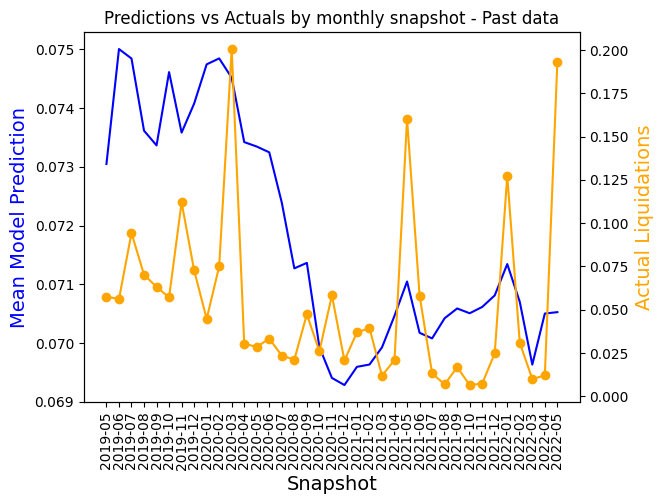

In [40]:
monitoring_curve(df_test_past, 'Predictions vs Actuals by monthly snapshot - Past data')